# Project: Investigate TMDB Movie Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The Movie Database (TMDb) is a community built movie and tv database. The dataset to be investigated was obtained from <a href='https://www.kaggle.com/tmdb/tmdb-movie-metadata/home'>Kaggle</a> and contains roughly 10,000 data points. The data includes information about a movie's budget, revenue, popularity (as defined by <a href="https://developers.themoviedb.org/3/getting-started/popularity">TMDb's metric</a>), genre, cast, etc.

An investigation of this dataset could potentially reveal trends in movie popularity and revenue generated - two key aspects that play an influential role in determining future movies to be produced.

The research questions to be investigated are as follows:
<b><ol>
<li>What properties influence movies with high revenue?</li>
<li>Which genres are most popular from year to year?</li>
<li>Which actors/actresses draw in the highest average revenue from their movies?</li>
</ol></b>

These questions will provide deeper insight into past and ongoing movie trends, thus allowing better understanding of the audience mentality and various factors that influence a movie's success.

In [101]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns

sns.set(font_scale=1.15)
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In this section, the general properties of the TMDb dataset are observed, and the data is cleaned and preprocessed for easier analysis in the subsequent sections.

In [3]:
#load data
df = pd.read_csv('tmdb-movies.csv')
#take a peek at the data
df.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [4]:
#drop any duplicates
df.drop_duplicates(inplace=True)

#check for duplicates
print("Duplicate entries: ",sum(df.duplicated()))

Duplicate entries:  0


In [5]:
#column names, number of rows and columns, column datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 21 columns):
id                      10865 non-null int64
imdb_id                 10855 non-null object
popularity              10865 non-null float64
budget                  10865 non-null int64
revenue                 10865 non-null int64
original_title          10865 non-null object
cast                    10789 non-null object
homepage                2936 non-null object
director                10821 non-null object
tagline                 8041 non-null object
keywords                9372 non-null object
overview                10861 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj              1

From the info cell above, we see that there are 10865 rows and 21 columns in the dataframe.

Based on the research questions, the following columns are considered as relevant and so should be retained:
<ul>
    <li>popularity</li> 
    <li>budget</li> 
    <li>revenue</li>
    <li>cast</li>
    <li>runtime</li>
    <li>genres</li>
    <li>release_year</li>
</ul>

Among these columns, cast and genres have missing values. Since these values are string formats, they will be filled in with a "missing" placeholder to simplify the data analysis process.

Irrelevant columns are dropped.

In [6]:
#fill the NAs with missing for easier processing
df.fillna("missing", inplace=True)

In [7]:
#keep only relevant columns
df = df[['popularity','budget','revenue','cast','runtime','genres','release_year']]
df.head(3)

,popularity,budget,revenue,cast,runtime,genres,release_year
0,32.985763,150000000,1513528810,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,124,Action|Adventure|Science Fiction|Thriller,2015
1,28.419936,150000000,378436354,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,120,Action|Adventure|Science Fiction|Thriller,2015
2,13.112507,110000000,295238201,Shailene Woodley|Theo James|Kate Winslet|Ansel...,119,Adventure|Science Fiction|Thriller,2015


The cast and genres columns contain various string values within a single row, separated by a "|" symbol. This is replaced by a list of the values instead for easy extraction later on.

In [8]:
#split cast, director, genres, and production_companies col values into lists
def split_col(col_name):
    for i in df.index:
        j = df[col_name][i]
        if j != 'missing':
            df.at[i,col_name] = j.split('|')
            
col_names = ['cast','genres']
for i in col_names:
    split_col(i)
    
df.head(3)

,popularity,budget,revenue,cast,runtime,genres,release_year
0,32.985763,150000000,1513528810,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",124,"[Action, Adventure, Science Fiction, Thriller]",2015
1,28.419936,150000000,378436354,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",120,"[Action, Adventure, Science Fiction, Thriller]",2015
2,13.112507,110000000,295238201,"[Shailene Woodley, Theo James, Kate Winslet, A...",119,"[Adventure, Science Fiction, Thriller]",2015


In [9]:
#Check basic statistics to check for anything out of the ordinary
df.describe()

,popularity,budget,revenue,runtime,release_year
count,10865.000000,1.086500e+04,1.086500e+04,10865.000000,10865.000000
mean,0.646446,1.462429e+07,3.982690e+07,102.071790,2001.321859
std,1.000231,3.091428e+07,1.170083e+08,31.382701,12.813260
min,0.000065,0.000000e+00,0.000000e+00,0.000000,1960.000000
25%,0.207575,0.000000e+00,0.000000e+00,90.000000,1995.000000
50%,0.383831,0.000000e+00,0.000000e+00,99.000000,2006.000000
75%,0.713857,1.500000e+07,2.400000e+07,111.000000,2011.000000
max,32.985763,4.250000e+08,2.781506e+09,900.000000,2015.000000


From the basic stat check above, we see that minimum values for budget, revenue, and runtime are zero. This is rather worrying since a legitimate movie should not have a 0-value budget, revenue, or runtime. In fact, for budget and revenue, even the median (50% quantile) still hovers around 0.

In [10]:
#Find number of time 0 occurs for budget, revenue, and runtime
print('Budget 0 count: ',df['budget'].value_counts()[0])
print('Revenue 0 count: ',df['revenue'].value_counts()[0])
print('Runtime 0 count: ',df['runtime'].value_counts()[0])

Budget 0 count:  5696
Revenue 0 count:  6016
Runtime 0 count:  31


Since the revenue is one of the central variables involved in the research question, I have decided to drop all rows where revenue is 0 in order to preserve the integrity of the data analysis. While it is possible that the movie simply generated no revenue whatsoever, the fact that there are no negative values makes this unlikely. As such, it is better to err on the side of caution and drop the rows instead.

I have also decided to drop all rows where budget is 0, since a comparison of how budget influences a film's revenue is important, and could be potentially biased if the zero budget yet non-zero revenue rows are included. I assume that a zero-budget film is simply not possible, and must be a form of missing data.

As runtime == 0 only constitutes a small amount of rows, and runtime is not that significant a factor to be analyzed, it is left in.

In [11]:
#keep rows where both revenue and budget are bigger than 0
df = df[(df['revenue'] > 0) & (df['budget'] > 0)]
print('Number of remaining rows: ',len(df))

Number of remaining rows:  3854


There are 3854 data points remaining, which may be less than half the size of our original dataset, but is still enough data points to draw some preliminary answers to satisfy the research questions.

The head and tail of the dataframe is checked to ensure that everything looks in place.

In [12]:
df.head(3)

,popularity,budget,revenue,cast,runtime,genres,release_year
0,32.985763,150000000,1513528810,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",124,"[Action, Adventure, Science Fiction, Thriller]",2015
1,28.419936,150000000,378436354,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",120,"[Action, Adventure, Science Fiction, Thriller]",2015
2,13.112507,110000000,295238201,"[Shailene Woodley, Theo James, Kate Winslet, A...",119,"[Adventure, Science Fiction, Thriller]",2015


In [13]:
df.tail(3)

,popularity,budget,revenue,cast,runtime,genres,release_year
10829,0.395668,4653000,6000000,"[John Wayne, Robert Mitchum, James Caan, Charl...",120,"[Action, Western]",1966
10835,0.299911,12000000,20000000,"[Steve McQueen, Richard Attenborough, Richard ...",182,"[Action, Adventure, Drama, War, Romance]",1966
10848,0.207257,5115000,12000000,"[Stephen Boyd, Raquel Welch, Edmond O'Brien, D...",100,"[Adventure, Science Fiction]",1966


As a final step in the data wrangling process, the "genre" column will be one-hot encoded so that more detailed analysis can be performed. The one-hot encoding is mainly for investigating correlation among categorical variables. 

Due to the large amount of different cast members in the dataset, I will be leaving the "cast" column as an array-like value so that simpler analysis can be performed, even if correlational insights are not possible.

In [14]:
#one hot encode genres column so that correlation analysis can be performed
mlb = MultiLabelBinarizer()

df_genres = pd.DataFrame(mlb.fit_transform(df['genres']),columns=mlb.classes_, index=df.index)

#peak
df_genres.head()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1: What properties influence movies with high revenue?

To investigate the properties that influence movies with high revenue, I will be constructing scatterplots of the various variables in the dataframe, alongside a heatmap of the different movie genre correlations. The aim is to identify the different correlational patterns between various movie features (popularity, budget, runtime, release_year, genre) and the generated revenue. While a correlation would not imply causation, it still provides insight regarding which properties tend to be associated with higher-revenue movies.

### Scatter Plots

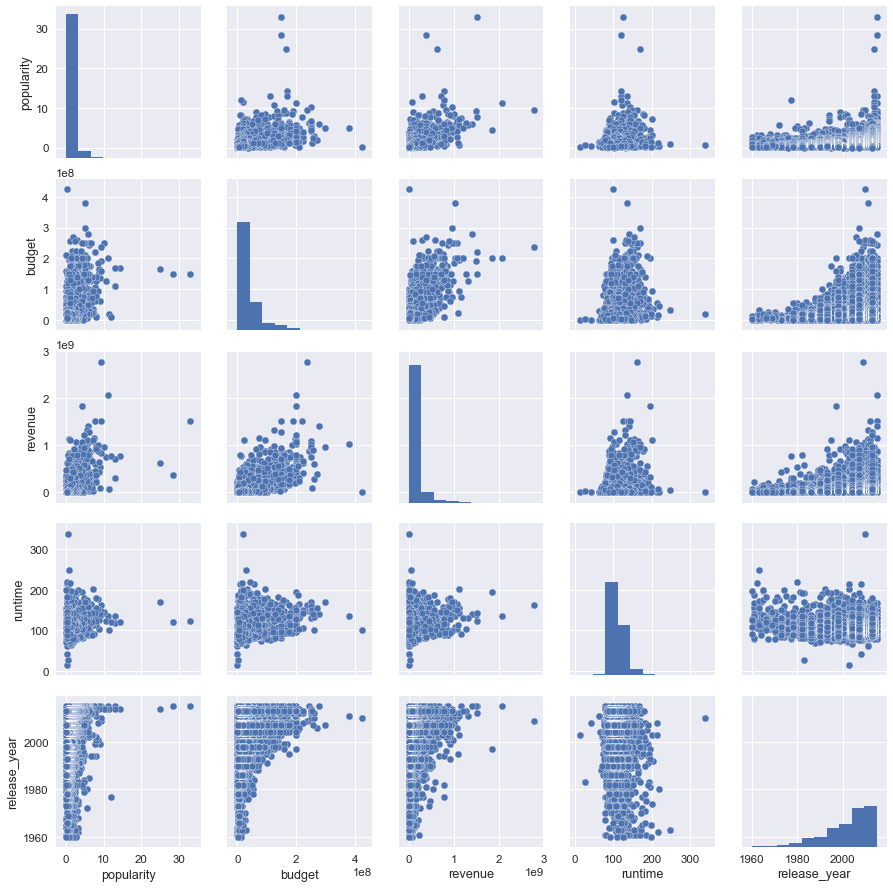

In [95]:
#create pairplot between numerical variables to observe patterns
sns.pairplot(df)

In [96]:
#calculate correlation coefficient between variables
num_var = ['budget','popularity','runtime','release_year' ]
for i in (num_var):
    print(f'Correlation coefficient between {i} vs revenue: %.2f' % np.corrcoef(df['revenue'], df[i])[0, 1])

Correlation coefficient between budget vs revenue: 0.69
Correlation coefficient between popularity vs revenue: 0.62
Correlation coefficient between runtime vs revenue: 0.25
Correlation coefficient between release_year vs revenue: 0.14


### Analysis

From the scatterplots and correlation coefficients calculated above, we see that budget has the higher correlation coefficient with revenue, followed by popularity, runtime, and release_year. This histograms reveal the expected behavior of popularity, budget, and revenue having exponential, right-skewed distributions; runtime having an approximately normal distribution, and release_year having an exponential, left-skewed distribution.

The clear positive correlation between budget and release_year, and popularity and release_year imply that the positive relationship between release_year and revenue could simply be due to its association with budget and popularity. This applies to all the other variables, and highlights one of the central reasons why causation cannot be inferred simply due to a correlation - confounding variables could be responsible for the correlational trend observed.

### Genre Heatmap

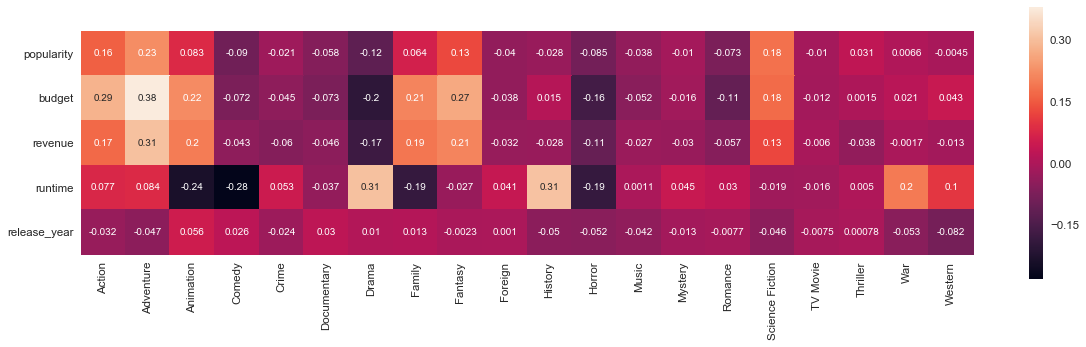

In [97]:
#plot heatmap of correlation between movie genres and numerical variables
genre_df = pd.concat([df, df_genres], axis=1, join_axes=[df.index])
f, ax = plt.subplots(figsize=(20, 5))
corr = genre_df.corr()
sns.heatmap(corr.iloc[:5,5:],square=True, ax=ax, annot=True)

### Analysis

From the genre heatmap, we can see the correlations among various genres and various movie features. It would appear that <b>Adventure</b> and <b>Animation</b> have the highest correlation coefficients with revenue (0.31, 0.2), followed by <b>Action</b>, <b>Fantasy</b>, and <b>Family</b>. <b>Science fiction</b> has the lowest positive correlation coefficient at 0.13, and all the other genres have negative correlations with revenue.

It should be noted that many of the genres that are highly-correlated with revenue are often highly-correlated with each other as well. A heatmap of genre-to-genre correlations is shown below to demonstrate this:

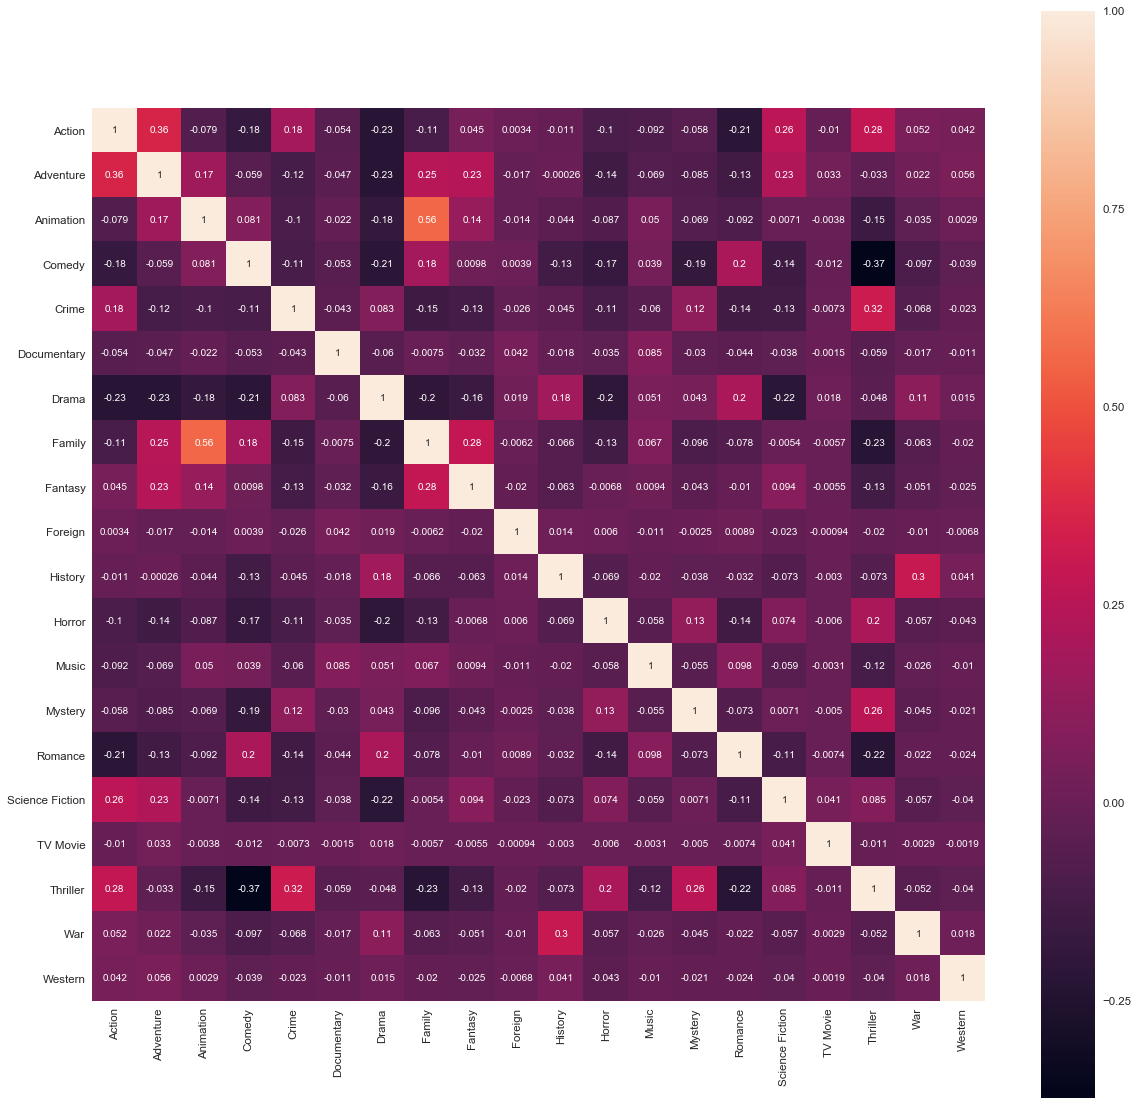

In [102]:
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr.iloc[5:,5:],square=True, ax=ax, annot=True)

From the heatmap, we see that Family and Animation have a relatively high correlation coefficient (0.56), as well as Adventure and Action (0.36). By observing the genre-to-genre correlation heatmap, we can identify the most correlated genre combinations in movies. Since most movies often consist of a combination of genres, as opposed to a single genre in isolation, a simple one-to-one correlation of genre vs revenue generated as shown above cannot be used as strong evidence for a causal relationship. 

### Research Question 2: Which genres are most popular from year to year?

In order to investigate which genres are most popular from year to year, the number of movies with that specific genre is divided by the total number of movies in a given year to obtain specific genre ratios on a yearly basis. For example, if there were 2 <b>Action</b> movies produced that year, and 10 movies in total, the genre ratio for <b>Action</b> would be 2/10 = 0.2.

In [105]:
#count number of movies in each genre for each year in the dataframe
dct = {}

for i,row in genre_df.iterrows():
    if row['release_year'] not in dct.keys():
        dct[row['release_year']] = {}
    else:
        for genre in list(df_genres):
            if genre not in dct[row['release_year']].keys():
                dct[row['release_year']][genre] = 0
                if row[genre] == 1:
                    dct[row['release_year']][genre] += 1
            else:
                if row[genre] == 1:
                    dct[row['release_year']][genre] += 1

yearly_genre_df = pd.DataFrame(dct)

#sort the columns in ascending order by year
yearly_genre_df = yearly_genre_df.reindex(sorted(yearly_genre_df.columns), axis=1)

#peak
yearly_genre_df.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Action,2,2,1,1,0,1,2,3,2,0,...,37,39,51,40,51,57,40,49,44,36
Adventure,1,1,2,1,0,1,2,4,2,1,...,33,23,40,33,30,31,24,32,28,33
Animation,0,0,0,0,0,0,0,0,0,0,...,12,9,11,12,10,14,11,13,10,9
Comedy,2,3,0,1,3,1,0,5,0,0,...,64,54,59,66,69,72,54,47,48,52
Crime,0,1,1,0,1,0,0,4,1,1,...,27,36,26,22,27,25,24,34,17,24


In [106]:
#create new df with total movie counts per year across all genres
yearly_movies = pd.DataFrame({'total_movies': yearly_genre_df.sum()})

#peak
yearly_movies.head()

,total_movies
1960,11
1961,20
1962,13
1963,16
1964,19


In [20]:
#get the ratio of genre/total number of movies per year so that 
#proportion of movies during that year is more accurately represented

for column in yearly_genre_df:
    yearly_genre_df[column] = yearly_genre_df[column]/yearly_genre_df[column].sum()

#peak
yearly_genre_df.head()

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Action,0.181818,0.10,0.076923,0.0625,0.000000,0.083333,0.181818,0.083333,0.083333,0.000000,...,0.082405,0.088036,0.109914,0.084388,0.109208,0.114,0.102041,0.114219,0.115183,0.090680
Adventure,0.090909,0.05,0.153846,0.0625,0.000000,0.083333,0.181818,0.111111,0.083333,0.142857,...,0.073497,0.051919,0.086207,0.069620,0.064240,0.062,0.061224,0.074592,0.073298,0.083123
Animation,0.000000,0.00,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.026726,0.020316,0.023707,0.025316,0.021413,0.028,0.028061,0.030303,0.026178,0.022670
Comedy,0.181818,0.15,0.000000,0.0625,0.157895,0.083333,0.000000,0.138889,0.000000,0.000000,...,0.142539,0.121896,0.127155,0.139241,0.147752,0.144,0.137755,0.109557,0.125654,0.130982
Crime,0.000000,0.05,0.076923,0.0000,0.052632,0.000000,0.000000,0.111111,0.041667,0.142857,...,0.060134,0.081264,0.056034,0.046414,0.057816,0.050,0.061224,0.079254,0.044503,0.060453


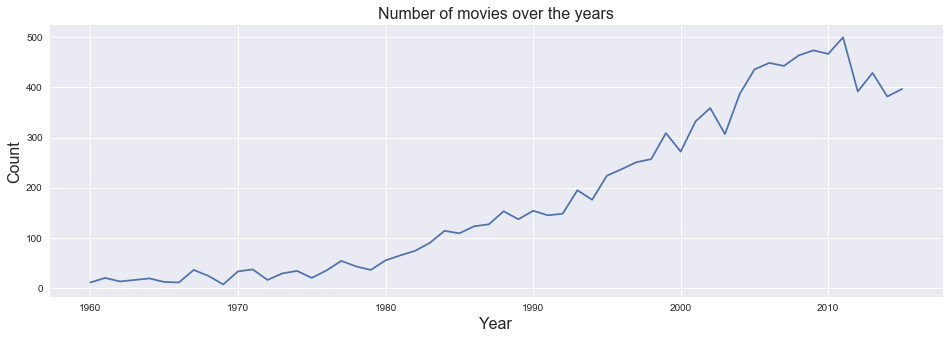

In [42]:
#plot number of movies over time
plt.figure(figsize=(16, 5))
plt.title('Number of movies over the years',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Count',fontsize=16)
plt.plot(yearly_movies)

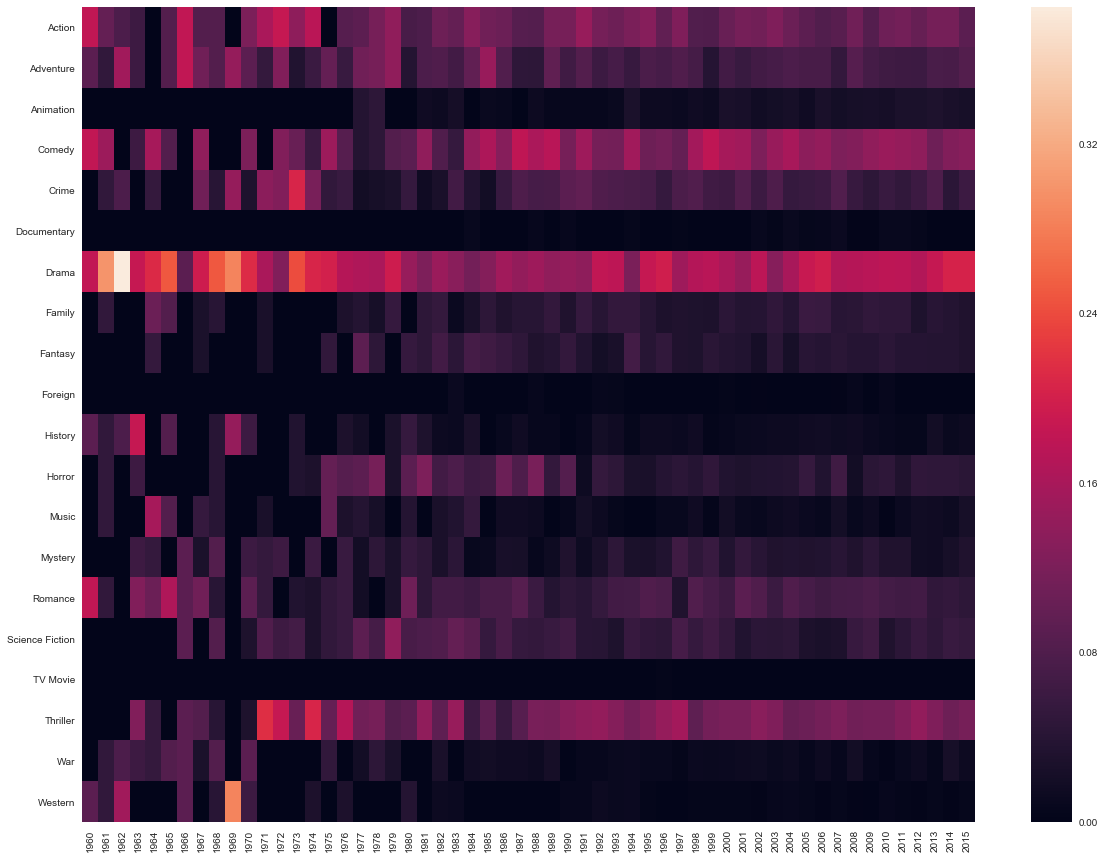

In [41]:
#heatmap of genre ratio over the years
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(yearly_genre_df, ax=ax)

### Analysis

From the plot of number of movies over the years, we see that the number of movies in the dataset increases over the years, reaching a peak around 2010. As such, a genre ratio is used to compare movie genre popularity from year-to-year, as opposed to the raw genre count.

From the genre ratio heatmap, we see that <b>Drama</b> is the most popular movie genre, and reached peak popularity around <b>1960 - 1973</b>. While its popularity decreased after that time period, it still remains one the relatively more popular genres. The lighter colors of the heatmap for <b>Action</b>, <b>Comedy</b>, and <b>Thriller</b> indicate that these genres are also relatively popular throughout the years compared to the other genres. <b>Western</b> seemed to have a sudden peak of popularity in the year of <b>1969</b>, but remained relatively unpopular for the other years.

### Research Question 3: Which actors/actresses draw in the highest average revenue from their movies?

The average revenue and total revenue across all movies for various actors/actresses are compared in order to investigate which actors/actressess tend to draw in the highest average revenue from their movies. Scatter plots of the relationship between number of movies, average revenue, and total revenue are plotted to investigate the potential correlation between these variables.

In [107]:
#create dictionary to record various revenues generated per movie for different actors/actresses
rev_dct = {}
    
for i,row in df.iterrows():
    for member in row['cast']:
        if member not in rev_dct:
            rev_dct[member] = [row['revenue']]
        else:
            rev_dct[member].append(row['revenue'])
            
#sum the number of items in each actor's revenue list to get the number of movies starred in 
#and avg_revenue across those movies
for k,v in rev_dct.items():
    rev_dct[k] = {'number_of_movies':len(v),'avg_revenue': np.mean(v),'total_revenue':sum(v)}

#Transpose the dataframe so that actors are rows and average revenue and number of movies are columns
rev_dct_df = pd.DataFrame(rev_dct).T.sort_values('avg_revenue',ascending=False)

#peak
rev_dct_df.head(10)

,avg_revenue,number_of_movies,total_revenue
Daisy Ridley,2.068178e+09,1.0,2.068178e+09
Nick Robinson,1.513529e+09,1.0,1.513529e+09
Jonathan Groff,1.274219e+09,1.0,1.274219e+09
Idina Menzel,1.274219e+09,1.0,1.274219e+09
Santino Fontana,1.274219e+09,1.0,1.274219e+09
Wendy Gazelle,1.106280e+09,1.0,1.106280e+09
Ken Howard,1.106280e+09,1.0,1.106280e+09
Miranda Cosgrove,9.707619e+08,1.0,9.707619e+08
Ken Stott,9.567599e+08,2.0,1.913520e+09
Bob Peck,9.201000e+08,1.0,9.201000e+08


The dataframe above shows that the actors/actresses with the highest average revenue appear to only have starred in one movie. This means that simply investigating the highest average revenue, without considering the number of movies or total revenue generated by the actor/actress could lead to potentially biased results of the financial success of an actor/actress. To account for this bias, I will plot bar charts of the top 20 highest average revenues while setting different lower limits for the number of movies starred in. I will also plot a bar chart of top 20 highest total revenues for comparison.

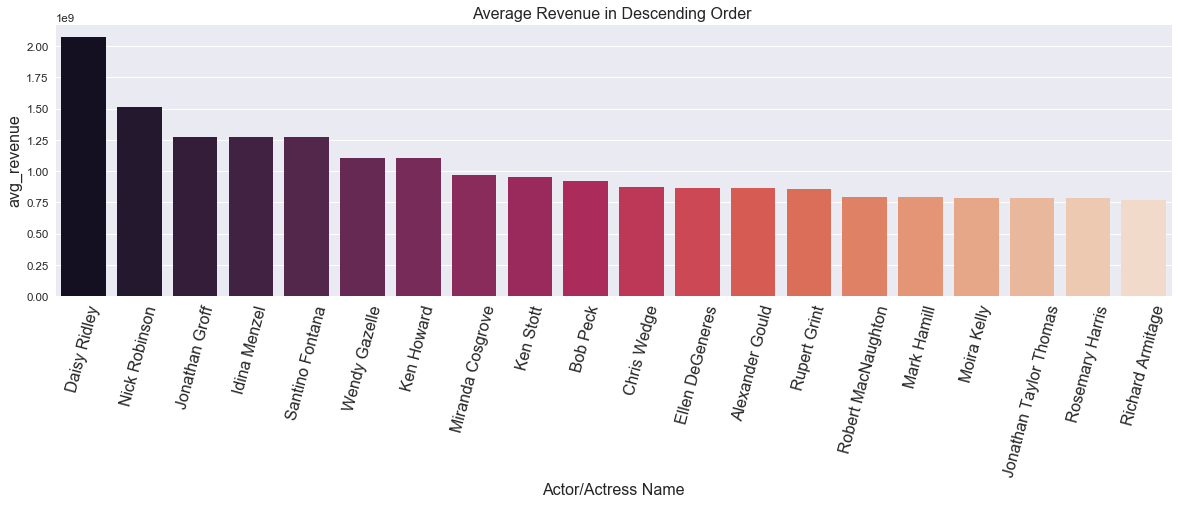

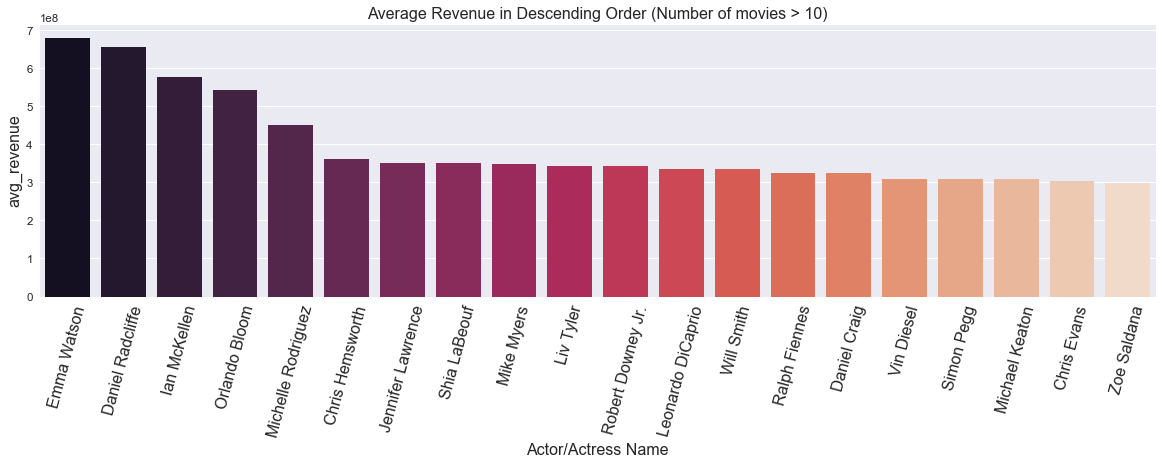

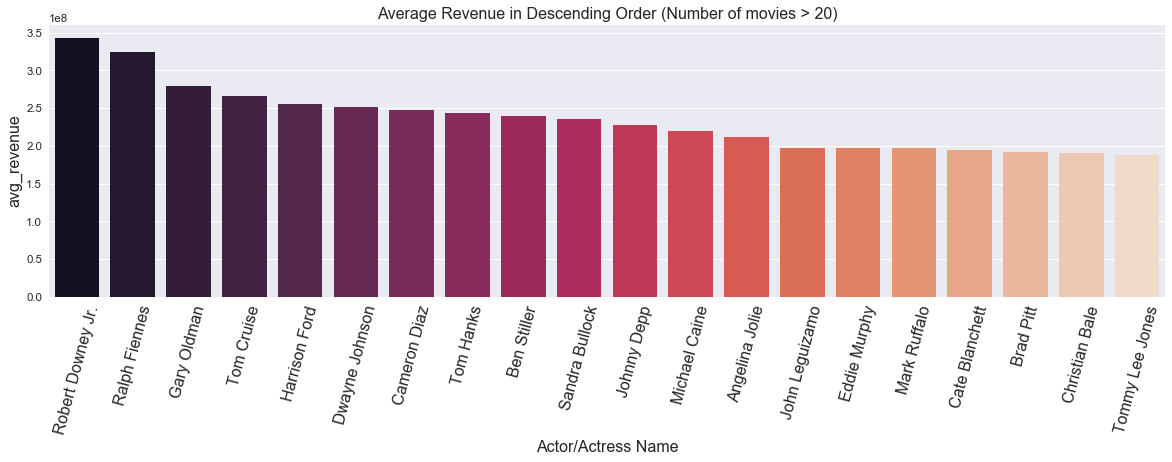

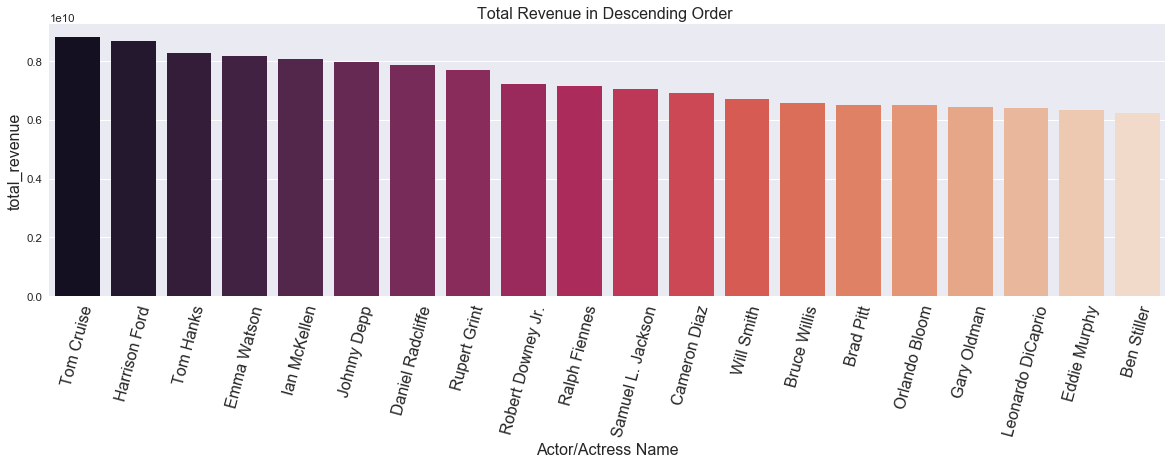

In [108]:
#check the 10 highest avg_revenue celebrities given various conditions
def plot_revenue(df,rev_type='avg',condition=''):
    if rev_type == 'avg': rev = 'Average' 
    else: rev = 'Total'
    plt.figure(figsize=(20, 5))
    plt.title(f'{rev} Revenue in Descending Order {condition}',fontsize=16)
    plt.xlabel('Actor/Actress Name',fontsize=16)
    plt.ylabel(f'{rev} Revenue (USD)',fontsize=16)
    plt.xticks(pos, df.index,rotation='75',fontsize=16)
    sns.barplot(x=df.index, y=f"{rev_type}_revenue", data=df, palette="rocket")

plot_revenue(rev_dct_df[:20])
plot_revenue(rev_dct_df[rev_dct_df['number_of_movies'] > 10 ][:20],condition='(Number of movies > 10)')
plot_revenue(rev_dct_df[rev_dct_df['number_of_movies'] > 20 ][:20],condition='(Number of movies > 20)')
plot_revenue(rev_dct_df.sort_values('total_revenue',ascending=False)[:20],rev_type='total')


If an actor/actress starred in a lot of movies that did not generate much revenue, they may have an inflated total revenue, which may not be a good representation of their revenue-generating capabilities. On the other hand, if an actor/actress only starred in one movie that performed extremely well, they may have a high average revenue which may not be a good representation of their revenue-generating capabilities either. 

In order to minimize these biases, we should use the bar chart with top 20 average revenues with a lower limit of at least 20 movies to ensure that the actors/actresses in the chart have a good track record of success (bigger sample size of past movies) and are more likely to generate high revenue in their next movie.

Correlation coefficient between number_of_movies vs total_revenue: 0.83
Correlation coefficient between number_of_movies vs avg_revenue: 0.18
Correlation coefficient between total_revenue vs avg_revenue: 0.46


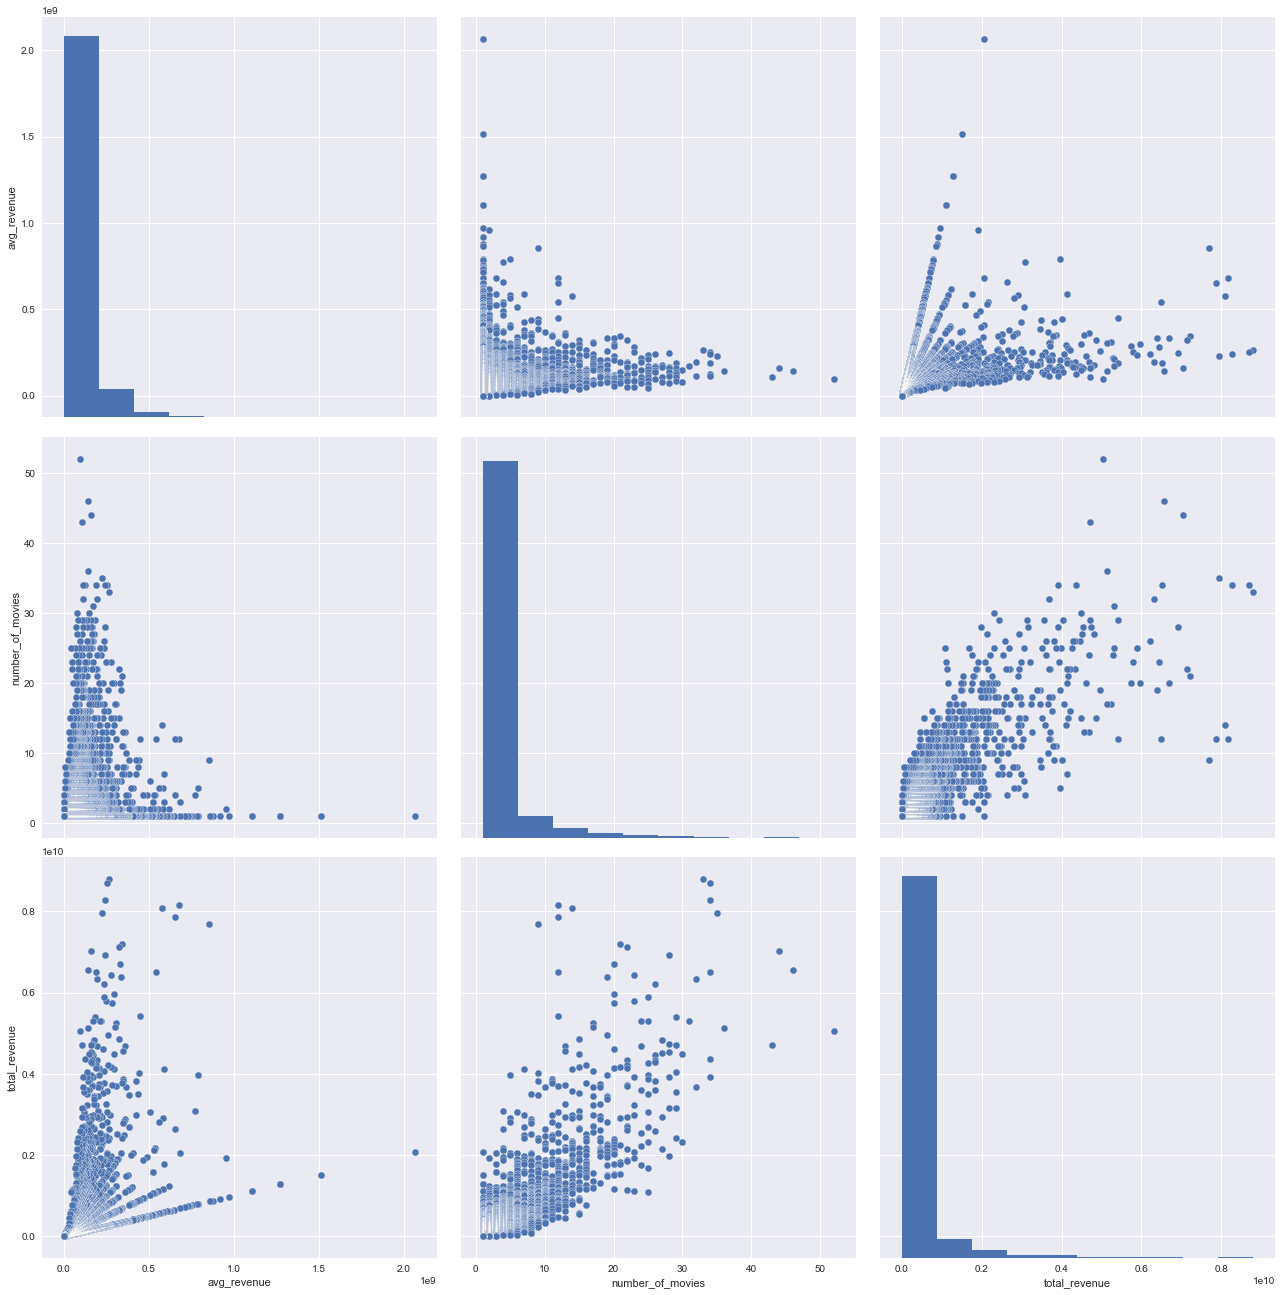

In [24]:
sns.pairplot(rev_dct_df,size=6)

#calculate correlation coefficient between variables
cols = ['number_of_movies','total_revenue','avg_revenue' ]
for i in range(len(cols)-1):
    for j in range(1,len(cols)):
        if i is not j:
            print(f'Correlation coefficient between {cols[i]} vs {cols[j]}: %.2f' 
                  % np.corrcoef(rev_dct_df[cols[i]], rev_dct_df[cols[j]])[0, 1])
    

The scatter plots and correlation coefficients calculated between average revenue, total revenue, and number of movies show a strong positive correlation between number of movies and total revenue (0.83) and a moderate strong correlation between average revenue and total revenue as well (0.46). The correlation between number of movies and average revenue is relatively low (0.18), which indicates that in the case of this TMDb dataset, starring in more movies does not neccessarily lead to higher average financial success.

<a id='conclusions'></a>
## Conclusions

Summary of findings to the three research questions:

<ol>
<li><b>What properties influence movies with high revenue?</b></li>
    <ul><li><b>Budget</b> and <b>popularity</b> have relatively high correlation coefficients with revenue (0.69, 0.62).</li></ul>
    <ul><li>Among the movie genres, <b>Adventure</b> and <b>Animation</b> have the highest correlation coefficients with revenue (0.31, 0.2).</li></ul>
    <br>
<li><b>Which genres are most popular from year to year (1960 - 2015)?</b></li>
    <ul><li><b>Drama</b> is the most popular movie genre throughout the years.</li></ul>
    <ul><li><b>Action</b>, <b>Comedy</b>, and <b>Thriller</b> also maintain a fair amount of popularity throughout the years.</li></ul>
    <ul><li><b>Western</b> had high popularity in 1969.</li></ul>
    <br>
<li><b>Which actors/actresses draw in the highest average revenue from their movies?</b></li>
    <ul><li>Top 5 actors/actresses with highest average revenue are: Daisy Ridley, Nick Robinson, Jonathan Groff, Idina Menzel, and Santino Fontana.</li></ul>
    <ul><li>Top 5 actors/actresses with highest average revenue with at least 20 movies are: Robert Downey Jr., Ralph Fiennes, Gary Oldman, Tom Cruise, and Harrison Ford.</li></ul>
    <ul><li>As mentioned in the analysis portion, by setting a lower limit to the number of movies, we get a more accurate representation of the actor/actresses' financial success by minimizing the bias of using a small sample size to calculate the average revenue.</li></ul>
    <ul><li>There is low correlation between number of movies and average revenue (0.18), which indicates that number of movies starred in is not a good predictor for an actor/actresses' average revenue. However, there is a moderately positive correlation between total revenue and average revenue (0.46), which indicates that total revenue could be a fairly good predictor for an actor/actresses' average revenue.</li></ul>
</ol>

### Limitations
<ul>
    <li>These conclusions are drawn from analysis of the trimmed dataset of 3854 data points. As such, any generalized application of these conclusions will be subject to the necessary biases imposed by this limited and specific sample size.</li><br>
    <li>As only bivariate correlation was used to investigate the research questions, prediction can be inferred, but causation cannot be implied. Bivariate correlation does not account for numerous confounding factors.</li><br>
    <li>Pearson's correlation might not have been the right analytical method to use for some of the cases. For example, in comparing the correlation between movie genres and revenue: movies genres are a categorical variable, so an approach more suitable to finding correlations between categorical data could have been used instead.</li>
</ul>

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])